# 3장 분류 문제 둘러보기(타이타닉 데이터셋)

> 타이타닉 데이터셋으로 머신러닝의 전반적인 내용을 살펴봅니다.
- author: "Chansung Park"
- toc: true
- comments: true
- permalink: /chapter3/
- badges: true

# 3.2 필요한 패키지

In [ ]:
#hide

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#hide

!pip install pandas==0.23.4
!pip install sklearn==0.21.0
!pip install yellowbrick==0.9

ERROR: Could not find a version that satisfies the requirement sklearn==0.21.0 (from versions: 0.0)
ERROR: No matching distribution found for sklearn==0.21.0
     |████████████████████████████████| 286kB 695kB/s 
     |████████████████████████████████| 12.8MB 8.8MB/s 
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: plotnine 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.23.4 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement pandas>=0.25.0, but you'll have pandas 0.23.4 which is incompatible.
ERROR: fbprophet 0.7.1 has requirement pandas>=1.0.4, but you'll have pandas 0.23.4 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.2.2
    Uninstalling matp

In [ ]:
#hide

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import (
  ensemble,
  preprocessing,
  tree
)
from sklearn.metrics import (
  auc,
  confusion_matrix,
  roc_auc_score,
  roc_curve
)
from sklearn.model_selection import (
  train_test_split,
  StratifiedKFold
)
from yellowbrick.classifier import (
  ConfusionMatrix,
  ROCAUC
)
from yellowbrick.model_selection import (
  LearningCurve
)

# 3.5 데이터의 수집

In [ ]:
url = "https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.xls"
df = pd.read_excel(url)
orig_df = df

In [ ]:
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'],
      dtype='object')

# 3.6 데이터의 정리

In [ ]:
df.dtypes

pclass         int64
survived       int64
name          object
sex           object
age          float64
sibsp          int64
parch          int64
ticket        object
fare         float64
cabin         object
embarked      object
boat          object
body         float64
home.dest     object
dtype: object

In [ ]:
df.shape

(1309, 14)

In [ ]:
df.describe().iloc[:, :2]

,pclass,survived
count,1309.000000,1309.000000
mean,2.294882,0.381971
std,0.837836,0.486055
min,1.000000,0.000000
25%,2.000000,0.000000
50%,3.000000,0.000000
75%,3.000000,1.000000
max,3.000000,1.000000


In [ ]:
df.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [ ]:
mask = df.isnull().any(axis=1)

In [ ]:
mask.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [ ]:
df[mask].body.head()

0      NaN
1      NaN
2      NaN
3    135.0
4      NaN
Name: body, dtype: float64

In [ ]:
df.sex.value_counts(dropna=False)

male      843
female    466
Name: sex, dtype: int64

In [ ]:
 df.embarked.value_counts(dropna=False)

S      914
C      270
Q      123
NaN      2
Name: embarked, dtype: int64

# 3.7 특징의 생성

In [ ]:
name = df.name
name.head(3)

0     Allen, Miss. Elisabeth Walton
1    Allison, Master. Hudson Trevor
2      Allison, Miss. Helen Loraine
Name: name, dtype: object

In [ ]:
df = df.drop(
    columns=["name",
             "ticket",
             "home.dest",
             "boat",
             "body",
             "cabin"]
    )

In [ ]:
df = pd.get_dummies(df)

In [ ]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [ ]:
df = df.drop(columns="sex_male")

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
df.columns

Index(['pclass', 'survived', 'age', 'sibsp', 'parch', 'fare', 'sex_female',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

In [ ]:
y = df.survived
X = df.drop(columns="survived")

# 3.8 샘플 데이터

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# 3.9 데이터의 대치

In [ ]:
from sklearn.experimental import (
  enable_iterative_imputer,
)
from sklearn import impute

In [ ]:
num_cols = [
  "pclass",
  "age",
  "sibsp",
  "parch",
  "fare",
  "sex_female",
]

In [ ]:
imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(
  X_train[num_cols]
)
X_train.loc[:, num_cols] = imputed
imputed = imputer.transform(X_test[num_cols])
X_test.loc[:, num_cols] = imputed

In [ ]:
meds = X_train.median()
X_train = X_train.fillna(meds)
X_test = X_test.fillna(meds)

In [ ]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_female,embarked_C,embarked_Q,embarked_S
1214,3.0,26.984481,0.0,0.0,8.6625,0.0,0,0,1
677,3.0,26.000000,0.0,0.0,7.8958,0.0,0,0,1
534,2.0,19.000000,0.0,0.0,26.0000,1.0,0,0,1
1174,3.0,0.437798,8.0,2.0,69.5500,1.0,0,0,1
864,3.0,28.000000,0.0,0.0,7.7750,1.0,0,0,1


# 3.10 데이터의 표준화

In [ ]:
cols = "pclass,age,sibsp,fare".split(",")
sca = preprocessing.StandardScaler()

In [ ]:
X_train = sca.fit_transform(X_train)
X_train = pd.DataFrame(X_train[:, :4], columns=cols)
X_test = sca.transform(X_test)
X_test = pd.DataFrame(X_test[:, :4], columns=cols)

# 3.11 리팩터링

In [ ]:
def tweak_titanic(df):
  df = df.drop(
    columns=[
      "name",
      "ticket",
      "home.dest",
      "boat",
      "body",
      "cabin",
    ]
  ).pipe(pd.get_dummies, drop_first=True)
  return df

def get_train_test_X_y(df, y_col, size=0.3, std_cols=None):
  y = df[y_col]
  X = df.drop(columns=y_col)
  X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=size, random_state=42
  )
  cols = X.columns
  num_cols = [
    "pclass",
    "age",
    "sibsp",
    "parch",
    "fare",
  ]

  fi = impute.IterativeImputer()

  X_train.loc[:, num_cols] = fi.fit_transform(X_train[num_cols])
  X_test.loc[:, num_cols] = fi.transform(X_test[num_cols])

  if std_cols:
    std = preprocessing.StandardScaler()
    X_train.loc[:, std_cols] = std.fit_transform(X_train[std_cols])
    X_test.loc[:, std_cols] = std.transform(X_test[std_cols])

  return X_train, X_test, y_train, y_test  

In [ ]:
ti_df = tweak_titanic(orig_df)
std_cols = "pclass,age,sibsp,fare".split(",")

X_train, X_test, y_train, y_test = get_train_test_X_y(ti_df, "survived", std_cols=std_cols)

# 3.12 베이스라인 모델

In [ ]:
from sklearn.dummy import DummyClassifier
bm = DummyClassifier()
bm.fit(X_train, y_train)
bm.score(X_test, y_test) # 정확도

0.5623409669211196

In [ ]:
from sklearn import metrics
metrics.precision_score(y_test, bm.predict(X_test))

0.44

# 3.13 다양한 알고리즘

In [ ]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [ ]:
from sklearn import model_selection
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
  LogisticRegression,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (
  KNeighborsClassifier,
)

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
  RandomForestClassifier,
)
import xgboost

In [ ]:
for model in [
  DummyClassifier,
  LogisticRegression,
  DecisionTreeClassifier,
  KNeighborsClassifier,
  GaussianNB,
  SVC,
  RandomForestClassifier,
  xgboost.XGBClassifier,
]:
  cls = model()
  kfold = model_selection.KFold(n_splits=10, random_state=42)
  s = model_selection.cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)
  print(f"{model.__name__:22} AUC: {s.mean():.3f} STD: {s.std():.2f}")

DummyClassifier        AUC: 0.523 STD: 0.03
LogisticRegression     AUC: 0.843 STD: 0.03
DecisionTreeClassifier AUC: 0.762 STD: 0.03
KNeighborsClassifier   AUC: 0.830 STD: 0.05
GaussianNB             AUC: 0.817 STD: 0.04
SVC                    AUC: 0.837 STD: 0.05
RandomForestClassifier AUC: 0.845 STD: 0.03
XGBClassifier          AUC: 0.863 STD: 0.04


# 3.14 스태킹

In [ ]:
from mlxtend.classifier import (
  StackingClassifier,
)

clfs = [
  x()
  for x in [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
  ]
]

stack = StackingClassifier(
  classifiers=clfs,
  meta_classifier=LogisticRegression(),
)

kfold = model_selection.KFold(n_splits=10, random_state=42)
s = model_selection.cross_val_score(stack, X, y, scoring="roc_auc", cv=kfold)
print(f"{stack.__class__.__name__} AUC: {s.mean():.3f} STD: {s.std():.2f}")

StackingClassifier AUC: 0.785 STD: 0.04


# 3.15 모델 만들기

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# 3.16 모델의 평가

In [ ]:
rf.score(X_test, y_test)

0.7837150127226463

In [ ]:
metrics.precision_score(y_test, rf.predict(X_test))

0.7916666666666666

In [ ]:
for col, val in sorted(zip(X_train.columns, 
                           rf.feature_importances_), 
                       key=lambda x: x[1],
                       reverse=True)[:5]:
  print(f"{col:10}{val:10.3f}")

age            0.285
fare           0.262
sex_male       0.241
pclass         0.089
sibsp          0.050


# 3.17 모델의 최적화

In [ ]:
rf4 = ensemble.RandomForestClassifier()
params = {
  "max_features": [0.4, "auto"],
  "n_estimators": [15, 200],
  "min_samples_leaf": [1, 0.1],
  "random_state": [42],
}

cv = model_selection.GridSearchCV(rf4, params, n_jobs=-1).fit(X_train, y_train)
print(cv.best_params_)

{'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 200, 'random_state': 42}


In [ ]:
rf5 = ensemble.RandomForestClassifier(
  **{
  "max_features": "auto",
  "min_samples_leaf": 0.1,
  "n_estimators": 200,
  "random_state": 42,
  }
)

rf5.fit(X_train, y_train)
rf5.score(X_test, y_test)

0.7073791348600509

# 3.18 오차 행렬

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = rf5.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[217,   7],
       [108,  61]])

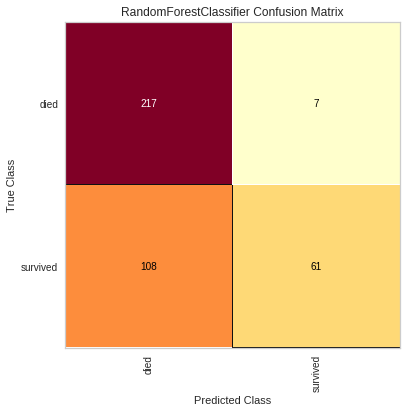

In [ ]:
mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))

cm_viz = ConfusionMatrix(
  rf5,
  classes=["died", "survived"],
  label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

plt.show()

# 3.19 ROC 곡선

In [ ]:
y_pred = rf5.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6648483727810651

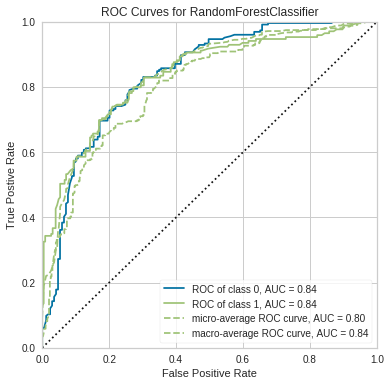

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
roc_viz = ROCAUC(rf5)
roc_viz.score(X_test, y_test)
roc_viz.poof()

plt.show()

# 3.20 학습 곡선

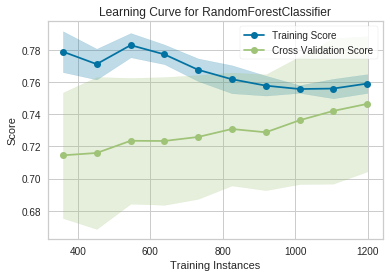

In [ ]:
import numpy as np
fig, ax = plt.subplots(figsize=(6, 4))

cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
  rf5,
  cv=cv,
  train_sizes=sizes,
  scoring="f1_weighted",
  n_jobs=4,
  ax=ax,
)

lc_viz.fit(X, y)
lc_viz.poof()

plt.show()

# 3.21 모델의 배포

In [ ]:
import pickle
pic = pickle.dumps(rf5)
rf6 = pickle.loads(pic)
y_pred = rf6.predict(X_test)
roc_auc_score(y_test, y_pred)

0.6648483727810651